# Advanced regridding of data

In this notebook we will explore some of the interpolation methods provided by the Regrid module. If no interpolation methods are specified, it will try to use a reasonable default for the given data (either linear or nearest neighbour); but if you understand your data and know what signal you want to preserve when you regrid it, there is a wealth of options to choose from. In this note book we will look at two examples:

* interpolate fire danger index data, preserving the highest warning levels
* interpolate precipitation data, using a method that conserves total values


## Preparations

We will only require the metview module for this example unless we wish to download data from the CDS.

In [1]:
import metview as mv

## Preserving maximum values when interpolating fire danger index data

We **retrieve** or **read** a fire danger risk forecast from the **CDS** - it comes on a **0.25 degree grid**.

The data comes from: https://cds.climate.copernicus.eu/cdsapp#!/dataset/cems-fire-historical?tab=overview.

In [2]:
use_cds = False # if False, then read data from disk

In [3]:
if use_cds:
    import zipfile
    import cdsapi
    c = cdsapi.Client()
    c.retrieve(
        'cems-fire-historical',
        {
            'format': 'zip',
            'product_type': 'reanalysis',
            'variable': [
                'danger_risk',
            ],
            'version': '3.1',
            'dataset': 'Consolidated dataset',
            'year': '2020',
            'month': '05',
            'day': '15',
        },
        'fire.zip')
    with zipfile.ZipFile('fire.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    fire = mv.read("ECMWF_FWI_DANGER_RISK_20200515_1200_hr_v3.1_con.nc")
else:
    filename = "ECMWF_FWI_DANGER_RISK_20200515_1200_hr_v3.1_con.nc"
    if mv.exist(filename):
        fire = mv.read(filename)
    else:
        fire = mv.gallery.load_dataset(filename)

### Initial plot
We will first plot the data on a global map using the cell_shading technique for speed.

In [4]:
fire.variables()

['time', 'longitude', 'latitude', 'danger_risk']

In [5]:
nvis = mv.netcdf_visualiser(netcdf_data=fire, 
                            netcdf_plot_type='geo_matrix',
                            netcdf_latitude_variable='latitude',
                            netcdf_longitude_variable='longitude',
                            netcdf_value_variable='danger_risk')

fire_shade_cell = mv.mcont(legend='on',
                      contour='off',
                      contour_level_selection_type='interval',
                      contour_interval=1,
                      contour_min_level=1,
                      contour_max_level=7,
                      contour_shade='on',
                      contour_shade_technique='cell_shading',
                      contour_shade_cell_resolution=20,
                      contour_shade_colour_method='palette',
                      contour_shade_palette_name='colorbrewer_Reds_6_r')

In [6]:
mv.setoutput('jupyter', output_font_scale=1.5, plot_widget=False)

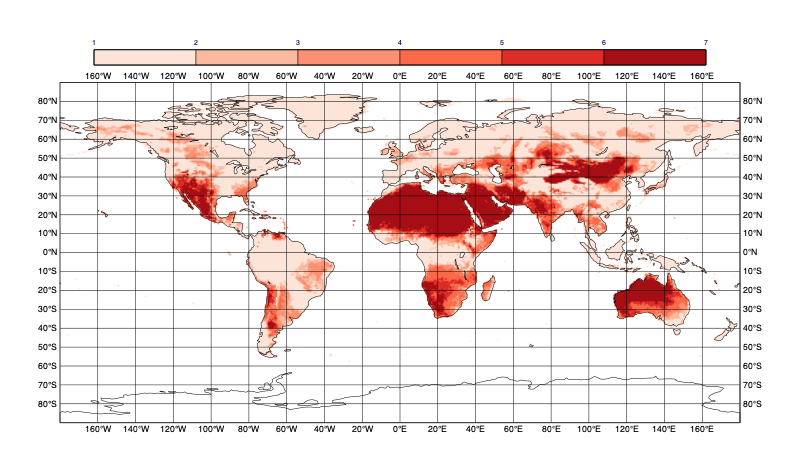

In [7]:
mv.plot(nvis, fire_shade_cell)

Now let's zoom into a smaller area and use the grid_shading technique to ensure we are plotting the exact grid cells as they appear in the data with no interpolations introduced by the plotting.

In [8]:
fire_shade_grid = mv.mcont(legend='on',
                      contour='off',
                      contour_level_selection_type='interval',
                      contour_interval=1,
                      contour_min_level=1,
                      contour_max_level=7,
                      contour_shade='on',
                      contour_shade_technique='grid_shading',
                      contour_shade_cell_resolution=20,
                      contour_shade_colour_method='palette',
                      contour_shade_palette_name='colorbrewer_Reds_6_r')

crete_map = mv.geoview(map_area_definition='corners',
                       area=[34, 22.5, 36, 27.5]) # [S,W,N,E]

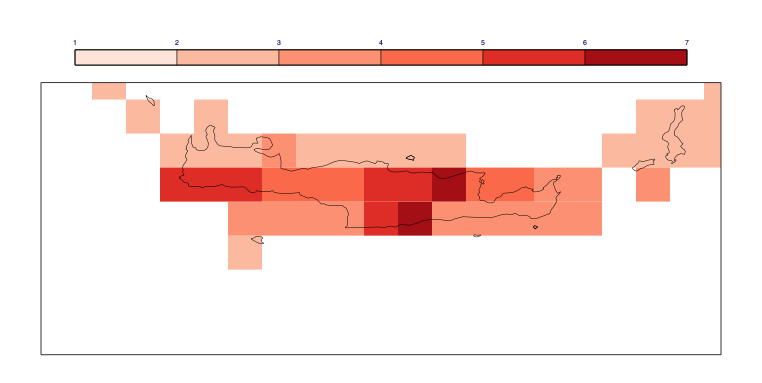

In [9]:
mv.plot(crete_map, nvis, fire_shade_grid)

We will regrid this data to a 1x1 degree grid cropped to an area of [33.2, 21.2, 38, 28] (S,W,N,E). We'll use a trick to plot the target grid by using the grid from the coastlines.

In [10]:
coast = mv.mcoast(map_coastline_thickness=1,
                  map_grid_thickness=2,
                  map_grid_colour="kelly_green",
                  map_grid_latitude_increment=1,
                  map_grid_longitude_increment=1,
                  map_grid_latitude_reference=33.2-0.5,
                  map_grid_longitude_reference=21.2-0.5)

crete_map = mv.geoview(map_area_definition='corners',
                       area=[34, 22.5, 36, 27.5],
                       coastlines=coast)

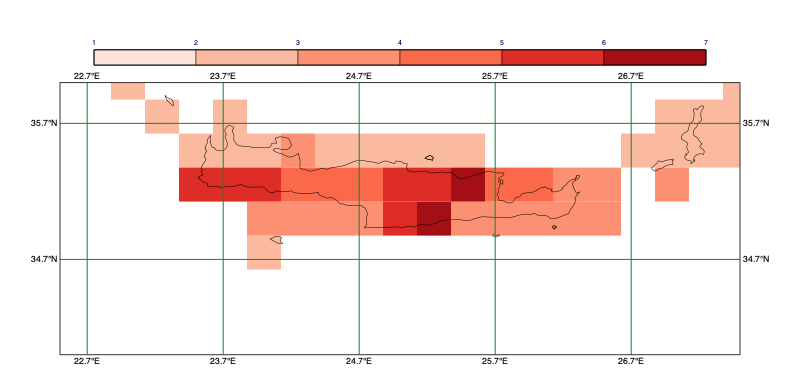

In [11]:
mv.plot(crete_map, nvis, fire_shade_grid)

To complete our initial plotting of the data, we will perform a simple regridding just to get the coordinates of the target grid points, replacing any missing values with real values, then plot the locations of these points over the original data. The target grid specification will be put into a dict so that we can re-use it with a different regridding technique later.

In [12]:
target_grid = {'grid':[1,1], 'area':[33.2, 21.2, 38, 28]} # S,W,N,E

In [13]:
fire_1x1_target_grid = mv.regrid(target_grid,
                                 data=fire)
fire_1x1_target_grid = fire_1x1_target_grid.nobitmap(0)

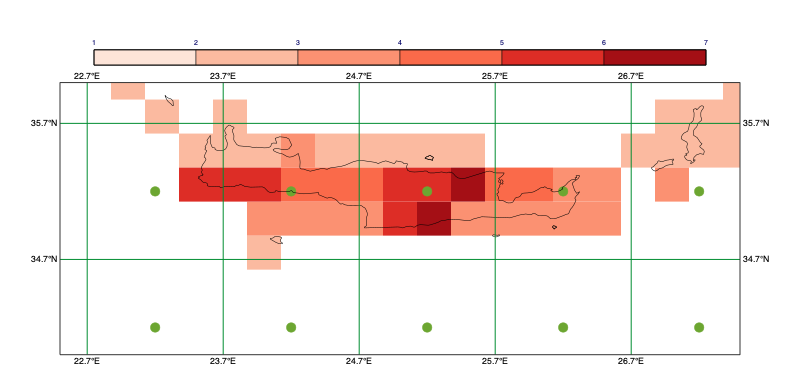

In [14]:
target_gridpoint_vis = mv.mcont(contour='off',
                                contour_grid_value_plot='on',
                                contour_grid_value_plot_type='marker',
                                contour_grid_value_marker_colour='avocado',
                                contour_grid_value_marker_index=15,
                                contour_grid_value_marker_height=0.7)

empty_title = mv.mtext(text_line_count=0)

mv.plot(crete_map, nvis, fire_shade_grid, fire_1x1_target_grid, target_gridpoint_vis, empty_title)

### Regridding via nearest neighbour technique
We will first use a common technique - for each target point, select the source point that is closest to it. As we will see, this method, although often useful, throws away a lot of data.

In [15]:
fire_1x1_nearest = mv.regrid(target_grid,
                             data=fire,
                             interpolation='nearest_neighbour')

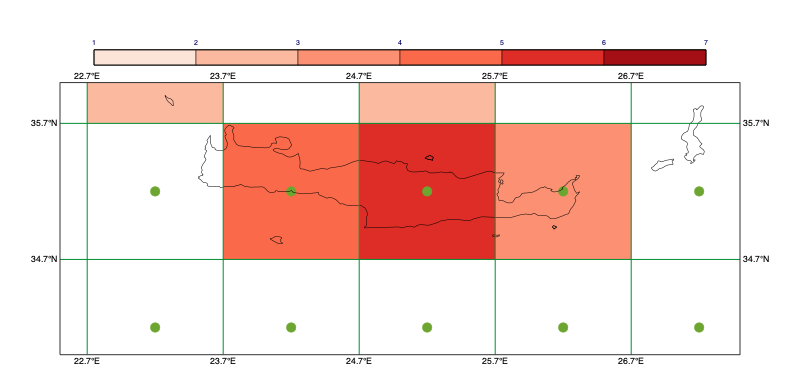

In [16]:
mv.plot(crete_map, fire_1x1_nearest, fire_shade_grid, fire_1x1_target_grid, target_gridpoint_vis, empty_title)

As you can see by comparing this plot to the previous one, the source value closest to each target point (green dots) was chosen, and the rest of the source values were not used at all; some target grid boxes ended up with a risk level of zero, even though they cover an area where the original data contained larger risk values.

Let's use a different regridding technique to use instead the maximum source value from each target grib box.

In [17]:
fire_1x1_max = mv.regrid(target_grid,
                         data=fire,
                         interpolation='grid_box_statistics',
                         interpolation_statistics='maximum')

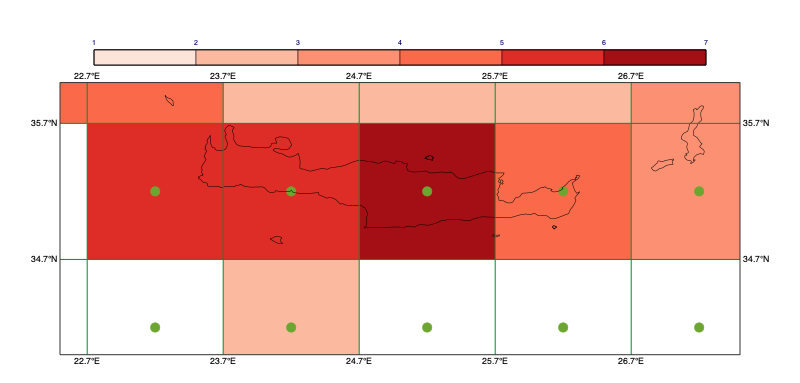

In [18]:
mv.plot(crete_map, fire_1x1_max, fire_shade_grid, fire_1x1_target_grid, target_gridpoint_vis, empty_title)

We now preserve the maximum risk level from each area. Note that this may or may not be what you want to do with this data - the regridding technique you use is up to you!